___

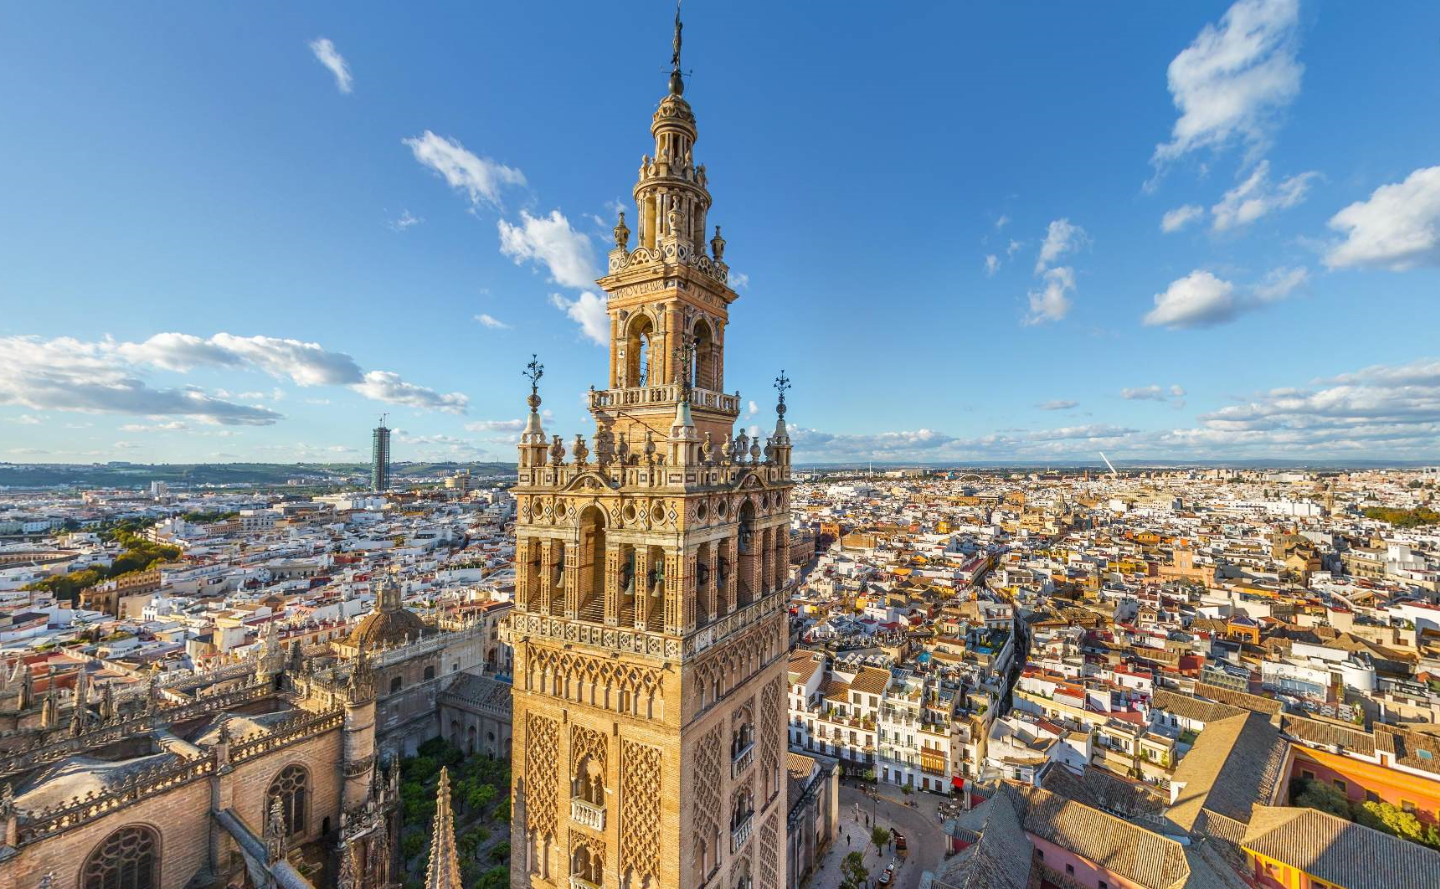

<center>

# Sevilla - Pasado y futuro: un análisis de la segmentación actual de barrios
____

<center>
    
#### Proyecto final del curso "Data Science Coursera Capstone Project"
    

<center>

##### Pablo de la Asunción Cumbrera Conde

#### Sevilla es una ciudad del sur de España (Andalucía) con 688.000 habitantes (2019). Hogar con legado de diferentes culturas (judía, musulmana y cristiana) posee una gran riqueza cultural como histórica. La ciudad que podemos visitar a día de hoy es herencia de todos los periodos históricos, albergando muchos y diferentes estilos de vida en cada uno de sus barrios.

-  ¿Cuánto de lejos ha quedado aquella Sevilla que se dividía en tres formas de habitar la ciudad, dependiendo de la cultura en la que había nacido?

#### Para comprobar si podríamos comenzar a establecer la base de un estudio que pudiera afirmar la existencia de un paralelismo histórico entre la segmentación que caracterizaba la ciudad del pasado y la del presente trabajaremos la siguiente hipótesis
-   ¿Cuál es la segmentación actual de los barrios de Sevilla dependiendo de los servicios que ofrece?

#### Para ello, seguiremos el siguiente proceso:
 -  Importamos librerias que nos puedan ser útiles
 -  Generaremos un Data Frame con los barrios de Sevilla
 -  Incluiremos en el Data Frame la longitud y latitud de cada barrio
 -  Visualizaremos estos resultados
 -  Utilizaremos la API de Foursquare para obtener los datos de los servicios más concurridos en cada barrio
 -  Utilizaremos una forma de agrupación (Clustering: K-Means) con los datos anteriores
 -  Visualizaremos la segmentación de barrios similares
 


#### El proyecto tendrá tres partes diferenciadas:
-  Datos
-  Método
-  Resultados

___

In [36]:
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from bs4 import BeautifulSoup
import csv

#!pip install geocoder
import geocoder # to get longitude and latitude

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # Map plotting library
import numpy as np
from pandas.io.json import json_normalize # Tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# Import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


usage: conda-script.py [-h] [-V] command ...
conda-script.py: error: unrecognized arguments: # uncomment this line if you haven't completed the Foursquare API lab


## Datos
___

In [37]:
path = "file:///C:/Users/pablo/Downloads/barrios%20sevilla.xls"

In [38]:
print ("Las primeras cinco filas de nuestra base de datos")
sevilla_data=pd.read_excel(path)
sevilla_data.head()

Las primeras cinco filas de nuestra base de datos


Código distrito       Distrito              Barrio
0                1  Casco Antiguo             Alfalfa
1                1  Casco Antiguo              Arenal
2                1  Casco Antiguo  Encarnación-Regina
3                1  Casco Antiguo               Feria
4                1  Casco Antiguo               Museo

In [39]:
print ("Las últimas cinco filas de nuestra base de datos")
sevilla_data.tail()

Las últimas cinco filas de nuestra base de datos


Código distrito               Distrito  \
103               10  Bellavista-La Palmera   
104               10  Bellavista-La Palmera   
105               10  Bellavista-La Palmera   
106               11           Los Remedios   
107               11           Los Remedios   

                                     Barrio  
103                              Heliópolis  
104  Pedro Salvador-Las Palmeritas-Guadaira  
105    Sector Sur-La Palmera-Reina Mercedes  
106                            Los Remedios  
107                                 Tablada

In [40]:
del sevilla_data['Código distrito']

In [41]:
sevilla_data.shape

(108, 2)

In [42]:
# Iniciar variables
lat = []
lng = []
lat_lng_coords = None

# Get postcodes from neighbourhoods table
barrios = sevilla_data['Barrio']

# Store latitude and longitude values in lat and lng
for nh in barrios:
    g = geocoder.arcgis('{}, Sevilla, ES'.format(nh))
    lat_lng_coords = g.latlng
    lat.append(lat_lng_coords[0])
    lng.append(lat_lng_coords[1])

In [43]:
sev_data = sevilla_data
sev_data['Latitude'] = lat
sev_data['Longitude'] = lng

In [44]:
sev_data.head()

Distrito              Barrio  Latitude  Longitude
0  Casco Antiguo             Alfalfa  37.39135   -5.99311
1  Casco Antiguo              Arenal  37.38648   -5.99751
2  Casco Antiguo  Encarnación-Regina  37.39457   -5.99262
3  Casco Antiguo               Feria  37.39782   -5.99010
4  Casco Antiguo               Museo  37.39166   -5.99956

In [45]:
sev_data.shape

(108, 4)

#### Lets visit Sevilla (on a map)

In [46]:
address = 'Sevilla, Andalucia'
geolocator = Nominatim(user_agent="sevilla_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Sevilla are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Sevilla are 37.3886303, -5.9953403.


In [47]:
# create map of New York using latitude and longitude values
map_sevilla = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, distrito, barrios in zip(sev_data['Latitude'], sev_data['Longitude'], sev_data['Barrio'], sev_data['Distrito']):
    label = '{}, {}'.format('Distrito', 'Barrio')
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sevilla)  
    
map_sevilla

### Método
___

#### Now lets import Data from Foursquare API

In [48]:
CLIENT_ID = 'JSPX5JW3JS0IMMPZFV4RC3OKYMNMNMGUJUETGTDCVD2XEMA2' # your Foursquare ID
CLIENT_SECRET = 'INY1M5ETAYK2FYYBFLCRVYV0M2XLBKMAR2S3C4WGDUFLIJ2H' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JSPX5JW3JS0IMMPZFV4RC3OKYMNMNMGUJUETGTDCVD2XEMA2
CLIENT_SECRET:INY1M5ETAYK2FYYBFLCRVYV0M2XLBKMAR2S3C4WGDUFLIJ2H


In [49]:
# Gets the name of the category

def get_category_type(row):
    categories_list = row['Category']  
    
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [50]:
explore_df_list=[]

for i, nhood_name in enumerate(sev_data['Barrio']):  
    
    try :
        #Get neighbourhood data
        nhood_name = sev_data.loc[i, 'Barrio']
        nhood_lat = sev_data.loc[i, 'Latitude']
        nhood_lng = sev_data.loc[i, 'Longitude']

        radius = 1000 
        LIMIT = 30 

        url = 'https://api.foursquare.com/v2/venues/explore?client_id={} \
        &client_secret={}&ll={},{}&v={}&radius={}&limit={}'\
        .format(CLIENT_ID, CLIENT_SECRET, nhood_lat, nhood_lng, VERSION, radius, LIMIT)

        results = json.loads(requests.get(url).text)
        results = results['response']['groups'][0]['items']

        nearby = json_normalize(results) # Flatten JSON

        # Filter the columns
        filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
        nearby = nearby.loc[:, filtered_columns]

        # Rename the columns
        columns = ['Name', 'Category', 'Latitude', 'Longitude']
        nearby.columns = columns

        # Get the categories
        nearby['Category'] = nearby.apply(get_category_type, axis=1)    

        # Get the required data
        for i, name in enumerate(nearby['Name']):
            s_list = nearby.loc[i, :].values.tolist()  # Converts the numpy array to a python list
            f_list = [nhood_name, nhood_lat, nhood_lng] + s_list
            explore_df_list.append(f_list)
    
    except Exception as e:
        pass

<ipython-input-50-a6b398dde08e>:21: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby = json_normalize(results) # Flatten JSON


#### Now we crate a table with all our principal data

In [51]:
explore_sev = pd.DataFrame([item for item in explore_df_list])
explore_sev.columns = ['Barrio', 'Latitud Barrio', 'Longitud Barrio', 'Nombre Avenida', 'Categoria Avenida', 'Latitud Avenida', 'Longitud Avenida']
explore_sev.head()

Barrio  Latitud Barrio  Longitud Barrio      Nombre Avenida  \
0  Alfalfa        37.39135         -5.99311  Plaza del Salvador   
1  Alfalfa        37.39135         -5.99311         Perro Viejo   
2  Alfalfa        37.39135         -5.99311     Bar el Comercio   
3  Alfalfa        37.39135         -5.99311         La Libélula   
4  Alfalfa        37.39135         -5.99311     Heladería Bolas   

  Categoria Avenida  Latitud Avenida  Longitud Avenida  
0             Plaza        37.390027         -5.993214  
1  Tapas Restaurant        37.392880         -5.992899  
2              Café        37.390772         -5.992341  
3    Clothing Store        37.390671         -5.993307  
4    Ice Cream Shop        37.389838         -5.992372

In [52]:
explore_sev.shape

(2742, 7)

#### Con los datos disponibles analizaremos los distintos servicios más populares de cada barrio

In [53]:
sev_1hot = pd.get_dummies(explore_sev[['Categoria Avenida']], prefix="", prefix_sep="")


# Add neighbourhood column back to dataframe
sev_1hot['Barrio'] = explore_sev['Barrio'] 


# Move neighbourhood column to the first column
fixed_columns = [sev_1hot.columns[-1]] + sev_1hot.columns[:-1].values.tolist()
sev_1hot = sev_1hot[fixed_columns]

sev_1hot.head()

Barrio  ATM  American Restaurant  Aquarium  Argentinian Restaurant  \
0  Alfalfa    0                    0         0                       0   
1  Alfalfa    0                    0         0                       0   
2  Alfalfa    0                    0         0                       0   
3  Alfalfa    0                    0         0                       0   
4  Alfalfa    0                    0         0                       0   

   Art Gallery  Art Museum  Asian Restaurant  Athletics & Sports  \
0            0           0                 0                   0   
1            0           0                 0                   0   
2            0           0                 0                   0   
3            0           0                 0                   0   
4            0           0                 0                   0   

   Auto Workshop  BBQ Joint  Bakery  Bar  Basketball Court  Bed & Breakfast  \
0              0          0       0    0                 0                0   
1              0          0       0    0                 0                0   
2              0          0       0    0                 0                0   
3              0          0       0    0                 0                0   
4              0          0       0    0                 0                0   

   Beer Bar  Beer Garden  Beer Store  Big Box Store  Bistro  Boarding House  \
0         0            0           0              0       0               0   
1         0            0           0              0       0               0   
2         0            0           0              0       0               0   
3         0            0           0              0       0               0   
4         0            0           0              0       0               0   

   Bookstore  Boutique  Breakfast Spot  Brewery  Buffet  Burger Joint  \
0          0         0               0        0       0             0   
1          0         0               0        0       0             0   
2          0         0               0        0       0             0   
3          0         0               0        0       0             0   
4          0         0               0        0       0             0   

   Bus Station  Café  Camera Store  Candy Store  Castle  Chinese Restaurant  \
0            0     0             0            0       0                   0   
1            0     0             0            0       0                   0   
2            0     1             0            0       0                   0   
3            0     0             0            0       0                   0   
4            0     0             0            0       0                   0   

   Church  Clothing Store  Cocktail Bar  Coffee Shop  Concert Hall  \
0       0               0             0            0             0   
1       0               0             0            0             0   
2       0               0             0            0             0   
3       0               1             0            0             0   
4       0               0             0            0             0   

   Construction & Landscaping  Convenience Store  Cupcake Shop  Dance Studio  \
0                           0                  0             0             0   
1                           0                  0             0             0   
2                           0                  0             0             0   
3                           0                  0             0             0   
4                           0                  0             0             0   

   Deli / Bodega  Department Store  Dessert Shop  Diner  Dive Bar  \
0              0                 0             0      0         0   
1              0                 0             0      0         0   
2              0                 0             0      0         0   
3              0                 0             0      0         0   
4              0                 0     

In [54]:
sev_grouped = sev_1hot.groupby('Barrio').mean().reset_index()
sev_grouped.head()

Barrio  ATM  American Restaurant  Aquarium  \
0   Aeropuerto Viejo  0.0                  0.0       0.0   
1            Alfalfa  0.0                  0.0       0.0   
2              Amate  0.0                  0.0       0.0   
3             Arenal  0.0                  0.0       0.0   
4  Avenida de la Paz  0.0                  0.0       0.0   

   Argentinian Restaurant  Art Gallery  Art Museum  Asian Restaurant  \
0                0.045455     0.000000         0.0              0.00   
1                0.000000     0.033333         0.0              0.00   
2                0.000000     0.000000         0.0              0.00   
3                0.000000     0.000000         0.0              0.00   
4                0.000000     0.000000         0.0              0.04   

   Athletics & Sports  Auto Workshop  BBQ Joint    Bakery       Bar  \
0                 0.0            0.0   0.045455  0.000000  0.000000   
1                 0.0            0.0   0.000000  0.033333  0.033333   
2                 0.0            0.0   0.000000  0.000000  0.033333   
3                 0.0            0.0   0.000000  0.000000  0.000000   
4                 0.0            0.0   0.000000  0.040000  0.040000   

   Basketball Court  Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  \
0          0.000000              0.0       0.0          0.0    0.000000   
1          0.000000              0.0       0.0          0.0    0.033333   
2          0.033333              0.0       0.0          0.0    0.000000   
3          0.000000              0.0       0.0          0.0    0.000000   
4          0.040000              0.0       0.0          0.0    0.000000   

   Big Box Store    Bistro  Boarding House  Bookstore  Boutique  \
0           0.00  0.000000        0.000000        0.0       0.0   
1           0.00  0.000000        0.000000        0.0       0.0   
2           0.00  0.000000        0.033333        0.0       0.0   
3           0.00  0.033333        0.000000        0.0       0.0   
4           0.04  0.000000        0.000000        0.0       0.0   

   Breakfast Spot   Brewery  Buffet  Burger Joint  Bus Station  Café  \
0        0.045455  0.045455     0.0           0.0          0.0  0.00   
1        0.000000  0.033333     0.0           0.0          0.0  0.10   
2        0.000000  0.000000     0.0           0.0          0.0  0.00   
3        0.000000  0.033333     0.0           0.0          0.0  0.00   
4        0.000000  0.040000     0.0           0.0          0.0  0.04   

   Camera Store  Candy Store  Castle  Chinese Restaurant    Church  \
0           0.0          0.0     0.0            0.000000  0.000000   
1           0.0          0.0     0.0            0.000000  0.033333   
2           0.0          0.0     0.0            0.033333  0.000000   
3           0.0          0.0     0.0            0.000000  0.033333   
4           0.0          0.0     0.0            0.000000  0.000000   

   Clothing Store  Cocktail Bar  Coffee Shop  Concert Hall  \
0        0.000000      0.045455     0.000000      0.045455   
1        0.033333      0.000000     0.000000      0.000000   
2        0.000000      0.000000     0.033333      0.000000   
3        0.000000      0.000000     0.000000      0.000000   
4        0.040000      0.000000     0.000000      0.040000   

   Construction & Landscaping  Convenience Store  Cupcake Shop  Dance Studio  \
0                         0.0                0.0           0.0      0.000000   
1                         0.0                0.0           0.0      0.000000   
2                         0.0                0.0           0.0      0.033333   
3                         0.0                0.0           0.0      0.000000   
4                         0.0                0.0           0.0      0.000000   

   Deli / Bodega  Department Store  Dessert Shop  Diner  Dive Bar  \
0       0.000000               0.0      0.000000    0.0       0.0   
1       0.066667               0.0      0.000000    0.0       0.0   
2       0.000000        

In [55]:
sev_grouped.shape

(108, 139)

In [56]:
def top_common_venues(row, top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:top_venues]

#### Ahora realizaremos una tabla con los servicios más populares de cada barrio

In [57]:
top_venues = 10
indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Barrio']
for ind in np.arange(top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Barrio'] = sev_grouped['Barrio']

for ind in np.arange(sev_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = top_common_venues(sev_grouped.iloc[ind, :], top_venues)

neighbourhoods_venues_sorted.head()

Barrio 1st Most Common Venue 2nd Most Common Venue  \
0   Aeropuerto Viejo                 Hotel  Fast Food Restaurant   
1            Alfalfa      Tapas Restaurant                 Plaza   
2              Amate    Spanish Restaurant      Tapas Restaurant   
3             Arenal        Ice Cream Shop                 Hotel   
4  Avenida de la Paz    Spanish Restaurant                  Park   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                  Park           Supermarket    Spanish Restaurant   
1                  Café    Spanish Restaurant         Deli / Bodega   
2         Metro Station            Restaurant    Chinese Restaurant   
3    Spanish Restaurant         Historic Site                 Plaza   
4           Supermarket                Bakery               Brewery   

      6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0  Mediterranean Restaurant               Brewery            Restaurant   
1       Monument / Landmark        Ice Cream Shop               Brewery   
2                      Park                 Plaza        Boarding House   
3          Tapas Restaurant            Restaurant                Bistro   
4            Farmers Market  Fast Food Restaurant     Electronics Store   

  9th Most Common Venue 10th Most Common Venue  
0        Breakfast Spot         Lighting Store  
1            Beer Store                    Spa  
2          Dessert Shop            Coffee Shop  
3                Church          Deli / Bodega  
4                  Café          Big Box Store


##### A continuación aplicaremos K-Means a los datos

In [58]:
sev_grouped_clustering = sev_grouped.drop('Barrio', 1)

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

In [60]:
max_range = 10 #Max range 10 (número de Clusters)

from sklearn.metrics import silhouette_samples, silhouette_score


indices = []
scores = []

for man_clusters in range(2, max_range) :
    
    # Run k-means clustering
    man_gc = sev_grouped_clustering
    kmeans = KMeans(n_clusters = man_clusters, init = 'k-means++', random_state = 0).fit_predict(man_gc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(man_gc, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(man_clusters)
    scores.append(score)

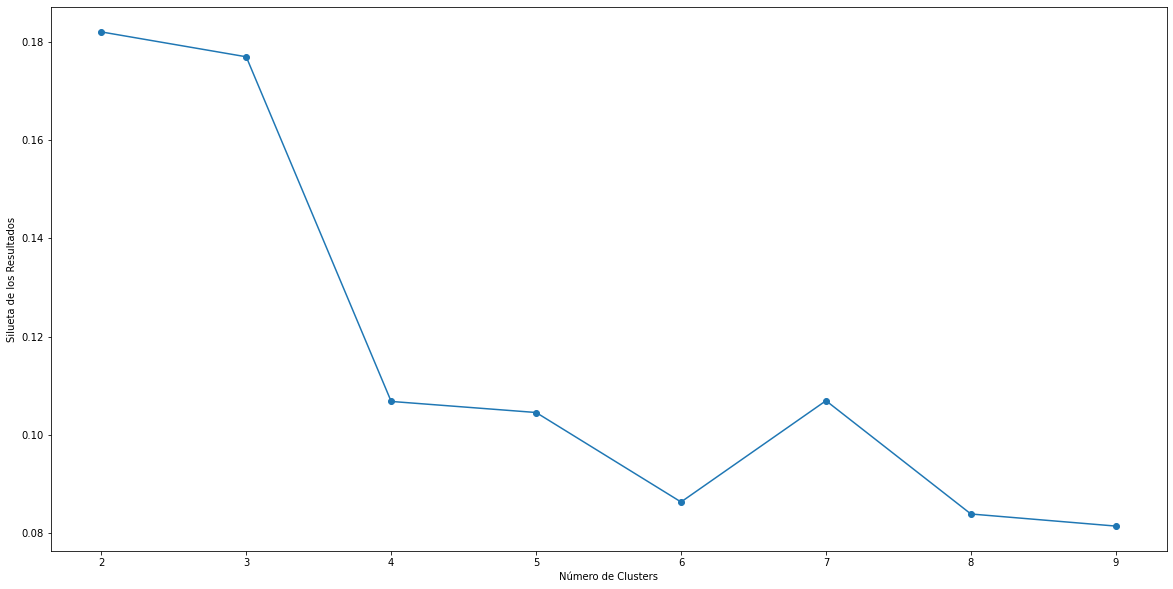

In [61]:
plot(max_range, scores, "Número de Clusters", "Silueta de los Resultados")

#### Siguiendo el "elbow method" nuestro número de Cluster óptimos es 4

In [62]:
opt_value = 6

#### Ahora que sabemos el valor óptimo procederemos a continuar el agrupamiento

In [63]:
sev_clusters = opt_value


# Run k-means clustering
sev_gc = sev_grouped_clustering
kmeans = KMeans(n_clusters = sev_clusters, init = 'k-means++', random_state = 0).fit(man_gc)

In [64]:
# añadimos etiquetas al Clustering
neighbourhoods_venues_sorted.insert(0,'Grupo', kmeans.labels_)

#### Finalmente, tenemos el gráfico de datos añadiendo los resultados del Clustering

In [65]:
sev_final = sev_data
sev_final = sev_final.join(neighbourhoods_venues_sorted.set_index('Barrio'), on='Barrio')
sev_final.dropna(inplace = True)
sev_final['Grupo'] = sev_final['Grupo'].astype(int)
sev_final.head()

Distrito              Barrio  Latitude  Longitude  Grupo  \
0  Casco Antiguo             Alfalfa  37.39135   -5.99311      3   
1  Casco Antiguo              Arenal  37.38648   -5.99751      3   
2  Casco Antiguo  Encarnación-Regina  37.39457   -5.99262      3   
3  Casco Antiguo               Feria  37.39782   -5.99010      3   
4  Casco Antiguo               Museo  37.39166   -5.99956      1   

  1st Most Common Venue 2nd Most Common Venue     3rd Most Common Venue  \
0      Tapas Restaurant                 Plaza                      Café   
1        Ice Cream Shop                 Hotel        Spanish Restaurant   
2      Tapas Restaurant                  Café                   Brewery   
3      Tapas Restaurant                  Café  Mediterranean Restaurant   
4      Tapas Restaurant    Spanish Restaurant                     Plaza   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0    Spanish Restaurant         Deli / Bodega   Monument / Landmark   
1         Historic Site                 Plaza      Tapas Restaurant   
2            Restaurant              Boutique                 Plaza   
3             Jazz Club              Beer Bar           Coffee Shop   
4                 Hotel                  Café        Ice Cream Shop   

             7th Most Common Venue 8th Most Common Venue  \
0                   Ice Cream Shop               Brewery   
1                       Restaurant                Bistro   
2                    Movie Theater            Beer Store   
3  Molecular Gastronomy Restaurant    Mexican Restaurant   
4                    Deli / Bodega            Restaurant   

      9th Most Common Venue    10th Most Common Venue  
0                Beer Store                       Spa  
1                    Church             Deli / Bodega  
2               Snack Place  Mediterranean Restaurant  
3                    Market                     Plaza  
4  Mediterranean Restaurant       Indie Movie Theater

### Resultados
___

#### Visualización de mapa de grupos (cluster)

In [66]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# Setup color scheme for different clusters
x = np.arange(sev_clusters)
ys = [i + x + (i*x)**2 for i in range(sev_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(sev_final['Latitude'], sev_final['Longitude'], sev_final['Barrio'], 
                                  sev_final['Grupo']):
    label = folium.Popup(str(poi) + ' (Grupo ' + str(cluster + 1) + ')', parse_html=True)
    map_clusters.add_child(
        folium.features.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7))
       
map_clusters

### Finalmente, entraremos al detalle de las características, barrios y servicios de cada grupo (cluster).

#### Grupo 1

In [67]:
val = 1
sev_final.loc[sev_final['Grupo'] == (val - 1), sev_final.columns[[0] + np.arange(4, sev_final.shape[1]).tolist()]]

Distrito  Grupo     1st Most Common Venue  \
11           Casco Antiguo      0                     Plaza   
27                Macarena      0               Supermarket   
35                Macarena      0            Breakfast Spot   
46             Cerro-Amate      0             Grocery Store   
49             Cerro-Amate      0            Breakfast Spot   
53                     Sur      0        Spanish Restaurant   
62                     Sur      0                      Park   
63                     Sur      0                      Park   
71                   Norte      0                     Hotel   
72                   Norte      0        Spanish Restaurant   
73                   Norte      0                   Brewery   
75                   Norte      0                      Park   
76                   Norte      0                   Brewery   
78                   Norte      0                   Brewery   
79                   Norte      0                   Brewery   
80                   Norte      0                   Brewery   
81                   Norte      0                      Park   
93   San Pablo-Santa Justa      0               Supermarket   
94   San Pablo-Santa Justa      0            Clothing Store   
96                    Este      0        Spanish Restaurant   
97                    Este      0        Spanish Restaurant   
99                    Este      0                      Food   
101  Bellavista-La Palmera      0  Mediterranean Restaurant   
107           Los Remedios      0        Italian Restaurant   

    2nd Most Common Venue          3rd Most Common Venue  \
11                   Park                         Garden   
27                Brewery                  Grocery Store   
35                Brewery                  Grocery Store   
46          Metro Station                           Park   
49                    ATM                       Pharmacy   
53                   Park                    Supermarket   
62         Clothing Store                  Grocery Store   
63           Soccer Field                            Gym   
71   Fast Food Restaurant                           Park   
72          Grocery Store                    Pizza Place   
73                   Park             Athletics & Sports   
75            Supermarket             Spanish Restaurant   
76     Athletics & Sports                    Supermarket   
78   Gym / Fitness Center                           Park   
79            Supermarket              Fish & Chips Shop   
80            Supermarket                 Lighting Store   
81           Cocktail Bar                    Supermarket   
93          Grocery Store  Paper / Office Supplies Store   
94             Restaurant               Department Store   
96                   Park            American Restaurant   
97             Steakhouse                       Pharmacy   
99     Miscellaneous Shop                 Sandwich Place   
101    Spanish Restaurant                    Supermarket   
107            Restaurant                            Bar   

    4th Most Common Venue 5th Most Common Venue     6th Most Common Venue  \
11                Theater        Nightlife Spot       Monument / Landmark   
27                  Plaza              Wine Bar                     Hotel   
35       Tapas Restaurant           Supermarket                 Gastropub   
46       Tapas Restaurant        Ice Cream Shop                Steakhouse   
49                  Plaza      Department Store             Event Service   
53                 Bakery               Brewery            Farmers Market   
62      Electronics Store    Spanish Restaurant          Basketball Court   
63          Grocery Store           Golf Course              Concert Hall   
71            Supermarket    Spanish Restaurant  Mediterranean Restaurant   
72     Athletics & Sports                  Park               Supermarket   
73            Supermarket        Breakfast Spot                     Plaza   
75       Departme

#### Grupo 2

In [68]:
val = 2
sev_final.loc[sev_final['Grupo'] == (val - 1), sev_final.columns[[0] + np.arange(4, sev_final.shape[1]).tolist()]]

Distrito  Grupo 1st Most Common Venue  \
4            Casco Antiguo      1      Tapas Restaurant   
9            Casco Antiguo      1      Tapas Restaurant   
36                 Nervión      1      Tapas Restaurant   
37                 Nervión      1      Tapas Restaurant   
41                 Nervión      1    Spanish Restaurant   
44             Cerro-Amate      1    Spanish Restaurant   
45             Cerro-Amate      1    Spanish Restaurant   
48             Cerro-Amate      1    Spanish Restaurant   
50             Cerro-Amate      1    Spanish Restaurant   
51             Cerro-Amate      1    Spanish Restaurant   
52                     Sur      1    Spanish Restaurant   
54                     Sur      1      Tapas Restaurant   
55                     Sur      1    Spanish Restaurant   
56                     Sur      1      Tapas Restaurant   
59                     Sur      1      Tapas Restaurant   
60                     Sur      1      Tapas Restaurant   
64                     Sur      1    Spanish Restaurant   
65                     Sur      1      Tapas Restaurant   
66                  Triana      1      Tapas Restaurant   
68                  Triana      1      Tapas Restaurant   
69                  Triana      1    Spanish Restaurant   
70                  Triana      1    Spanish Restaurant   
83                   Norte      1    Italian Restaurant   
85   San Pablo-Santa Justa      1      Tapas Restaurant   
86   San Pablo-Santa Justa      1    Spanish Restaurant   
88   San Pablo-Santa Justa      1    Spanish Restaurant   
89   San Pablo-Santa Justa      1    Spanish Restaurant   
91   San Pablo-Santa Justa      1    Spanish Restaurant   
92   San Pablo-Santa Justa      1    Spanish Restaurant   
98                    Este      1                 Hotel   
103  Bellavista-La Palmera      1    Spanish Restaurant   
104  Bellavista-La Palmera      1    Spanish Restaurant   
105  Bellavista-La Palmera      1    Spanish Restaurant   
106           Los Remedios      1            Restaurant   

      2nd Most Common Venue   3rd Most Common Venue     4th Most Common Venue  \
4        Spanish Restaurant                   Plaza                     Hotel   
9        Spanish Restaurant               Gastropub              Dessert Shop   
36       Spanish Restaurant                     Bar                       Gym   
37       Spanish Restaurant  Argentinian Restaurant                       Bar   
41         Tapas Restaurant      Italian Restaurant                       Bar   
44         Tapas Restaurant           Metro Station                Restaurant   
45            Metro Station        Tapas Restaurant        Chinese Restaurant   
48     Fast Food Restaurant          Clothing Store             Grocery Store   
50            Metro Station        Tapas Restaurant                Steakhouse   
51            Grocery Store        Department Store          Video Game Store   
52         Tapas Restaurant                    Café                      Park   
54       Spanish Restaurant                   Hotel        Seafood Restaurant   
55     Fast Food Restaurant             Supermarket              Concert Hall   
56       Spanish Restaurant             Pizza Place                     Hotel   
59       Spanish Restaurant                    Café               Pizza Place   
60       Spanish Restaurant             Pizza Place  Mediterranean Restaurant   
64         Tapas Restaurant                   Hotel                      Café   
65       Spanish Restaurant                    Café               Pizza Place   
66       Spanish Restaurant              Restaurant                     Hotel   
68       Spanish Restaurant              Restaurant        Italian Restaurant   
69         Tapas Restaurant              Restaurant                       Bar   
70         Tapas Restaurant              Restaurant                       Bar   
83       Spanish Restaurant             Sports Club          Tapas Restaurant   
85      

#### Grupo 3

In [71]:
val = 3
sev_final.loc[sev_final['Grupo'] == (val - 1), sev_final.columns[[0] + np.arange(4, sev_final.shape[1]).tolist()]]

Distrito  Grupo       1st Most Common Venue 2nd Most Common Venue  \
74    Norte      2  Construction & Landscaping                Winery   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
74          Dessert Shop  Fast Food Restaurant        Farmers Market   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
74         Event Service     Electronics Store              Dive Bar   

   9th Most Common Venue 10th Most Common Venue  
74                 Diner       Department Store

#### Grupo 4

In [72]:
val = 4
sev_final.loc[sev_final['Grupo'] == (val - 1), sev_final.columns[[0] + np.arange(4, sev_final.shape[1]).tolist()]]

Distrito  Grupo 1st Most Common Venue  \
0            Casco Antiguo      3      Tapas Restaurant   
1            Casco Antiguo      3        Ice Cream Shop   
2            Casco Antiguo      3      Tapas Restaurant   
3            Casco Antiguo      3      Tapas Restaurant   
5            Casco Antiguo      3      Tapas Restaurant   
6            Casco Antiguo      3      Tapas Restaurant   
7            Casco Antiguo      3                  Café   
8            Casco Antiguo      3      Tapas Restaurant   
10           Casco Antiguo      3      Tapas Restaurant   
12                Macarena      3      Tapas Restaurant   
13                Macarena      3      Tapas Restaurant   
14                Macarena      3      Tapas Restaurant   
15                Macarena      3                  Café   
16                Macarena      3      Tapas Restaurant   
17                Macarena      3      Tapas Restaurant   
18                Macarena      3      Tapas Restaurant   
19                Macarena      3      Tapas Restaurant   
20                Macarena      3      Tapas Restaurant   
21                Macarena      3      Tapas Restaurant   
22                Macarena      3      Tapas Restaurant   
23                Macarena      3      Tapas Restaurant   
24                Macarena      3      Tapas Restaurant   
25                Macarena      3      Tapas Restaurant   
26                Macarena      3      Tapas Restaurant   
28                Macarena      3      Tapas Restaurant   
29                Macarena      3      Tapas Restaurant   
30                Macarena      3      Tapas Restaurant   
31                Macarena      3      Tapas Restaurant   
32                Macarena      3           Coffee Shop   
33                Macarena      3      Tapas Restaurant   
34                Macarena      3      Tapas Restaurant   
38                 Nervión      3      Tapas Restaurant   
39                 Nervión      3      Tapas Restaurant   
40                 Nervión      3      Tapas Restaurant   
42                 Nervión      3      Tapas Restaurant   
43                 Nervión      3      Tapas Restaurant   
47             Cerro-Amate      3      Tapas Restaurant   
57                     Sur      3      Tapas Restaurant   
58                     Sur      3                 Plaza   
61                     Sur      3      Tapas Restaurant   
67                  Triana      3      Tapas Restaurant   
77                   Norte      3      Tapas Restaurant   
82                   Norte      3      Tapas Restaurant   
84   San Pablo-Santa Justa      3      Tapas Restaurant   
87   San Pablo-Santa Justa      3      Tapas Restaurant   
90   San Pablo-Santa Justa      3      Tapas Restaurant   
95   San Pablo-Santa Justa      3      Tapas Restaurant   
100  Bellavista-La Palmera      3      Tapas Restaurant   
102  Bellavista-La Palmera      3      Tapas Restaurant   

        2nd Most Common Venue     3rd Most Common Venue  \
0                       Plaza                      Café   
1                       Hotel        Spanish Restaurant   
2                        Café                   Brewery   
3                        Café  Mediterranean Restaurant   
5                      Museum                     Plaza   
6                        Café  Mediterranean Restaurant   
7            Tapas Restaurant               Coffee Shop   
8          Spanish Restaurant                      Café   
10                      Plaza                      Café   
12                  Gastropub               Pizza Place   
13                     Bakery        Spanish Restaurant   
14         Spanish Restaurant        Athletics & Sports   
15           Tapas Restaurant               Coffee Shop   
16                       Café             Historic Site   
17   Mediterranean Restaurant             Historic Site   
18                      Hotel                     Plaza   
19                      Hotel               Pizza Place   
20   

#### Con respecto a los resultados podemos afirmar:
-  Los diferentes barrios de Sevilla se podrían dividir en 4 agrupaciones diferentes, siendo la tercera de ellas (grupo 3) un valor individual.
-  Como en el pasado, parece que la ciudad se segmenta en tres estilos de vida diferentes basado en la popularidad de los servicios que se ofrecen en los barrios descrtios

#### Para continuar con la investigación proponemos:
-  El estudio geográfico para comparar si hay correspondencia entre ambas segmentaciones geográficas.
-  Profundización en las causas del caso aislado del grupo 3.

___


  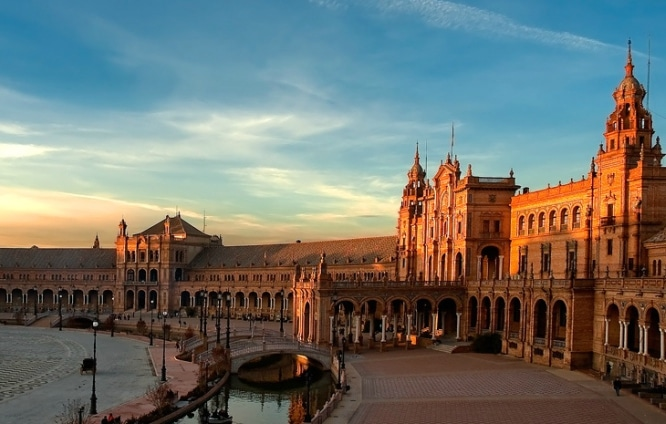